In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import copy
import random

In [138]:
# Load the dataset
filepath = './data_insurance.csv'  # Ensure this file is in your working directory
data = pd.read_csv(filepath)

# 1. Explore the Data
print("First few rows of the dataset:")
print(data.head())
print("\nData types of each column:")
print(data.dtypes)
print("\nSummary statistics:")
print(data.describe())

# 2. Handle Missing Data
print("\nChecking for missing values:")
print(data.isnull().sum())

# Handle missing values
# For numerical columns, fill missing values with the column's mean
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mean())

# For categorical columns, fill missing values with the most frequent value
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mode()[0])

print("\nDataset after handling missing values:")
print(data.isnull().sum())

# 3. Convert Categorical Variables
print("\nEncoding categorical variables...")

# Encode 'sex' and 'smoker' using Label Encoding
label_encoders = {}  # Dictionary to store label encoders for reference
for column in ['sex', 'smoker']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Encode 'region' using Label Encoding (assigns numeric labels to categories)
region_le = LabelEncoder()
data['region'] = region_le.fit_transform(data['region'])

print("\nData after encoding:")
print(data.head())

# 4. Define Features and Target
X = data.drop(columns=['charges']).values  # Independent variables
y = data['charges'].values                 # Dependent variable

print("\nShape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

# Save processed data if needed
processed_filepath = './processed_data.csv'
data.to_csv(processed_filepath, index=False)
print(f"\nProcessed data saved to {processed_filepath}.")


First few rows of the dataset:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Data types of each column:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Summary statistics:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400

In [139]:
# def random_feature_selection(X):
#     X_new = None
#     np.random.seed(48)
#     r = np.random.randint(3, 7)
#     X_new = X[:, :r]
#     return X_new
    
# X = random_feature_selection(X)
# print("Shape of X: ",X.shape, "Shape of y: ",y.shape)

In [140]:
## Data scaling and train-test split

def train_test_split(X, y, test_size=0.25, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    split_index = int(X.shape[0] * (1 - test_size))

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

def min_max_scaler(X, feature_range=(0, 1)):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)

    X_scaled = (X-X_min)/(X_max-X_min)

    return X_scaled


X = min_max_scaler(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Shape of X_train: ",X_train.shape, "Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape, "Shape of y_test: ",y_test.shape)

Shape of X_train:  (1003, 6) Shape of y_train:  (1003,)
Shape of X_test:  (335, 6) Shape of y_test:  (335,)


In [141]:
def loss_function(X, y, w, b):
    # number of training examples
    m = X.shape[0]
    y_matrix = y.reshape((m,1))
    predictions = np.dot(X, w.T) + b
    column_loss_vector = (predictions - y_matrix)
    square_loss_vector = np.square(column_loss_vector)
    loss = np.sum(square_loss_vector)/(2*m)
    return loss

In [142]:
def compute_gradient(X, y, w, b):
    # Number of training examples
    m = X.shape[0]

    dL_dw = None
    dL_db = None

    y_matrix = y.reshape((m,1))
    predictions = np.dot(X, w.T) + b
    errors = predictions - y_matrix
    dL_dw = np.dot(errors.T, X) / m
    dL_db = np.sum(errors) / m
    return dL_dw, dL_db

In [143]:
## CODE REQUIRED ##

def batch_gradient_descent(X, y, w_initial, b_initial, alpha, num_iters):
    # number of training examples
    m = X.shape[0]

    # to store loss values for every iteation as a list and print loss value after every 100 iterations
    loss_hist = []

    # Initialize parameters
    w = copy.deepcopy(w_initial) ## deepcopy is used so that the updates do not change the initial variable values
    b = b_initial

    for i in range(num_iters):
        dL_dw, dL_db = compute_gradient(X, y, w, b)
        w = w - alpha * dL_dw
        b = b - alpha * dL_db
        loss = loss_function(X, y, w, b)
        loss_hist.append(loss)
        if i % 100000 == 0:
            print(f"Iteration {i}: Loss = {loss}")
           
    return w, b, loss_hist

In [144]:
def initialize_parameters():
    initial_w = None
    initial_b = None
    alpha = None

    num_features = data.shape[1]
    initial_w = np.random.randn(1, num_features-1)
    initial_b = np.random.randn()
    alpha = random.uniform(0.00001, 0.0001)

    return initial_w,initial_b,alpha

In [145]:
# initialize the parameters and hyperparameter
initial_w, initial_b, alpha = initialize_parameters()

# number of iterations
num_iters = 10000000

w,b,loss_hist = batch_gradient_descent(X_train,y_train,initial_w,initial_b,alpha,num_iters)
print("Updated w: ",w)
print("Updated b: ",b)

Iteration 0: Loss = 163631735.7618246
Iteration 100000: Loss = 26808004.155384287
Iteration 200000: Loss = 20620030.892464165
Iteration 300000: Loss = 19299155.942987468
Iteration 400000: Loss = 18853769.745274182
Iteration 500000: Loss = 18631844.777550634
Iteration 600000: Loss = 18496438.257335175
Iteration 700000: Loss = 18405852.904831197
Iteration 800000: Loss = 18342355.233809967
Iteration 900000: Loss = 18296649.601447754
Iteration 1000000: Loss = 18263226.662925463
Iteration 1100000: Loss = 18238551.042311247
Iteration 1200000: Loss = 18220227.58547107
Iteration 1300000: Loss = 18206573.085888736
Iteration 1400000: Loss = 18196375.981558323
Iteration 1500000: Loss = 18188750.804476272
Iteration 1600000: Loss = 18183044.220852945
Iteration 1700000: Loss = 18178771.32590445
Iteration 1800000: Loss = 18175570.911872488
Iteration 1900000: Loss = 18173173.308027934
Iteration 2000000: Loss = 18171376.902241956
Iteration 2100000: Loss = 18170030.83306424
Iteration 2200000: Loss = 181

In [146]:
## Train and Test error computation
train_error = loss_function(X_train,y_train,w,b)
test_error = loss_function(X_test,y_test,w,b)
print("Train Error: ",train_error, ", Test Error: ",test_error)

Train Error:  18166005.690267228 , Test Error:  18624397.511475693


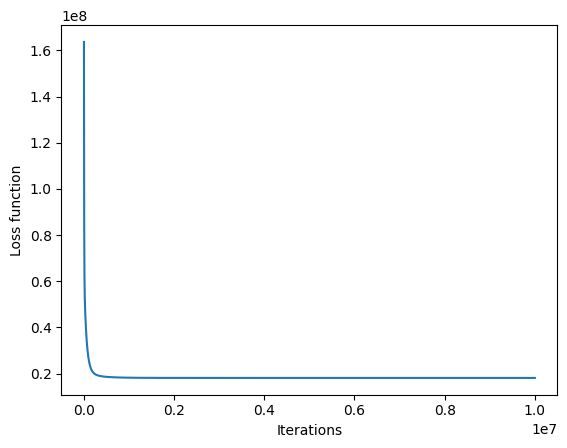

In [147]:
# PLotting the loss values for every training iterations
loss_plot = [loss_hist[i] for i in range(len(loss_hist))]
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.plot(loss_plot)
plt.show()

In [148]:
m = (X_test).shape[0]
y_matrix = (y_test).reshape((m,1))
y_pred = np.dot((X_test), w.T) + b

# Evaluate the Model
# 1. Mean Squared Error (MSE)
mse = np.mean((y_test - y_pred) ** 2)

# 2. R-squared (R²)
y_mean = np.mean(y_test)  # Mean of actual values
ss_res = np.sum((y_test - y_pred) ** 2)  # Residual Sum of Squares
ss_tot = np.sum((y_test - y_mean) ** 2)  # Total Sum of Squares
r2 = 1 - (ss_res / ss_tot)

print(f"Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Reshape w if necessary to ensure it's a 1D array
w_coeff = np.array(w).flatten()

# Feature names
feature_names = data.drop(columns=['charges']).columns

# Analyze Model Coefficients
print("Model Coefficients:")
for feature, coef in zip(feature_names, w_coeff):
    print(f"{feature}: {coef:.2f}")

# Optionally save coefficients to a file
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': w_coeff
})
coefficients_df.to_csv('./model_coefficients.csv', index=False)
print("\nModel coefficients saved to 'model_coefficients.csv'.")


Model Evaluation:
Mean Squared Error (MSE): 248137246.11
R-squared (R²): -578.73
Model Coefficients:
age: 12167.37
sex: -0.12
bmi: 11966.88
children: 2690.38
smoker: 23693.39
region: -1145.82

Model coefficients saved to 'model_coefficients.csv'.


In [151]:
"""
Manually choose the hyperparameters (learning rate and number of features) and train the model.
Then compare the performance with random chosen hyperparameters and manually chosen hyperparameters.
"""
r = 6   
alpha_manual = 0.001
num_iters = 1000000

# Load the dataset
filepath = './data_insurance.csv'  # Ensure this file is in your working directory
data = pd.read_csv(filepath)

# 1. Explore the Data
print("First few rows of the dataset:")
print(data.head())
print("\nData types of each column:")
print(data.dtypes)
print("\nSummary statistics:")
print(data.describe())

# 2. Handle Missing Data
print("\nChecking for missing values:")
print(data.isnull().sum())

# Handle missing values
# For numerical columns, fill missing values with the column's mean
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mean())

# For categorical columns, fill missing values with the most frequent value
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mode()[0])

print("\nDataset after handling missing values:")
print(data.isnull().sum())

# 3. Convert Categorical Variables
print("\nEncoding categorical variables...")

# Encode 'sex' and 'smoker' using Label Encoding
label_encoders = {}  # Dictionary to store label encoders for reference
for column in ['sex', 'smoker']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Encode 'region' using Label Encoding (assigns numeric labels to categories)
region_le = LabelEncoder()
data['region'] = region_le.fit_transform(data['region'])

print("\nData after encoding:")
print(data.head())

# 4. Define Features and Target
X = data.drop(columns=['charges']).values  # Independent variables
y = data['charges'].values                 # Dependent variable

print("\nShape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

# Save processed data if needed
processed_filepath = './processed_data1.csv'
data.to_csv(processed_filepath, index=False)
print(f"\nProcessed data saved to {processed_filepath}.")

X_new = min_max_scaler(X)
X_train_manual, X_test_manual, y_train_manual, y_test_manual = train_test_split(X_new, y, test_size=0.25, random_state=42)
print("Shape of X_train: ",X_train_manual.shape, "Shape of y_train: ",y_train_manual.shape)
print("Shape of X_test: ",X_test_manual.shape, "Shape of y_test: ",y_test_manual.shape)
initial_w = np.random.randn(1, r)
initial_b = np.random.randn()
w_manual,b_manual,loss_hist_manual = batch_gradient_descent(X_train_manual,y_train_manual,initial_w,initial_b,alpha_manual,num_iters)
print("Updated w_manual",w_manual)
print("Updated b_manual",b_manual)
train_error_manual = loss_function(X_train_manual,y_train_manual,w_manual,b_manual)
test_error_manual = loss_function(X_test_manual,y_test_manual,w_manual,b_manual)
print("Train Error manual: ",train_error_manual, ", Test Error manual: ",test_error_manual)

m = (X_test).shape[0]
y_matrix = (y_test).reshape((m,1))
y_pred = np.dot((X_test), w.T) + b

# Evaluate the Model
# 1. Mean Squared Error (MSE)
mse = np.mean((y_test - y_pred) ** 2)

# 2. R-squared (R²)
y_mean = np.mean(y_test)  # Mean of actual values
ss_res = np.sum((y_test - y_pred) ** 2)  # Residual Sum of Squares
ss_tot = np.sum((y_test - y_mean) ** 2)  # Total Sum of Squares
r2 = 1 - (ss_res / ss_tot)

print(f"Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Reshape w if necessary to ensure it's a 1D array
w_coeff = np.array(w).flatten()

# Feature names
feature_names = data.drop(columns=['charges']).columns

# Analyze Model Coefficients
print("Model Coefficients:")
for feature, coef in zip(feature_names, w_coeff):
    print(f"{feature}: {coef:.2f}")

# Optionally save coefficients to a file
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': w_coeff
})
coefficients_df.to_csv('./model_coefficients1.csv', index=False)
print("\nModel coefficients saved to 'model_coefficients1.csv'.")


First few rows of the dataset:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Data types of each column:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Summary statistics:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400